In [1]:
# import library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

In [2]:
# Camera Calibration

nx = 9
ny = 6


def find_imgobj_points():
    
    # array for obj points
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # read caibration images
    images = glob.glob("camera_cal/calibration*.jpg")
    
    # detect chess board corners
    for img_name in images:
        img = cv2.imread(img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    return objpoints, imgpoints


In [3]:
def camera_calibration(objpoints,imgpoints):
    img = cv2.imread('test_images/test1.jpg')
    image_shape = (img.shape[1], img.shape[0])
    ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)
    save_matrices(cameraMatrix, distortionCoeffs)
    return cameraMatrix, distortionCoeffs


def undistort_img(img):
    dst = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    return dst

def save_matrices(cameraMatrix, distortionCoeffs):
    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["cameraMatrix"] = cameraMatrix
    dist_pickle["distortionCoeffs"] = distortionCoeffs
    pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ))
    

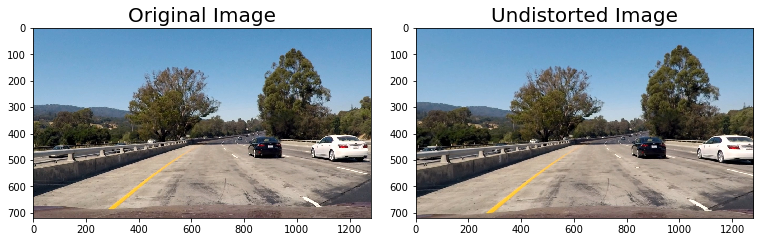

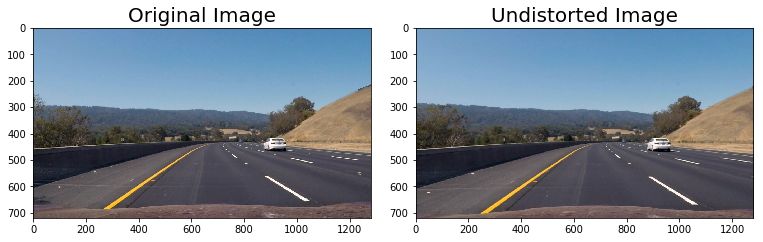

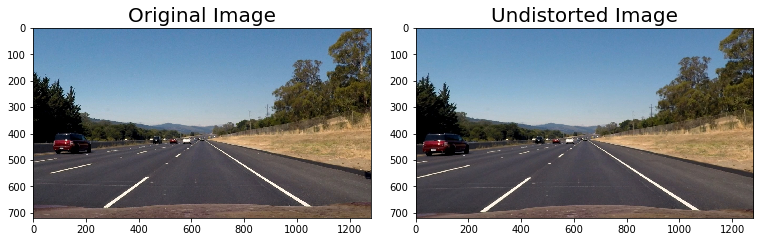

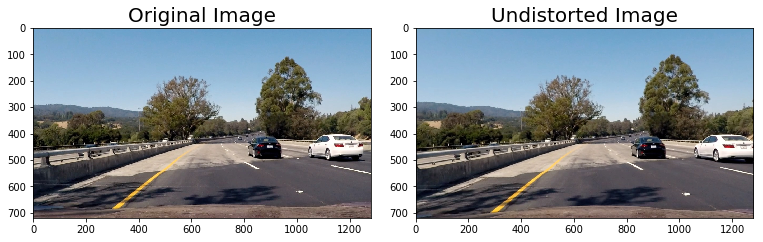

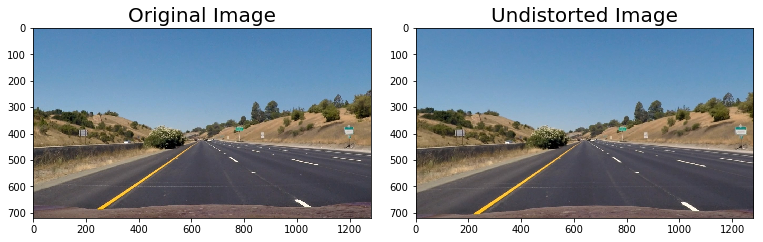

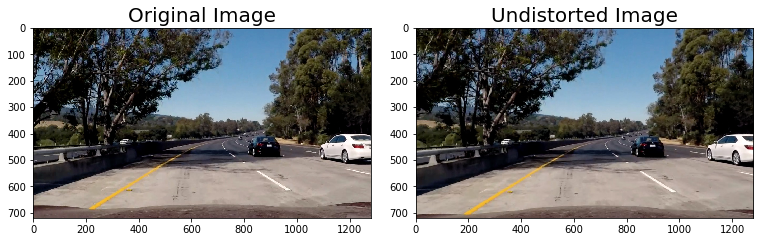

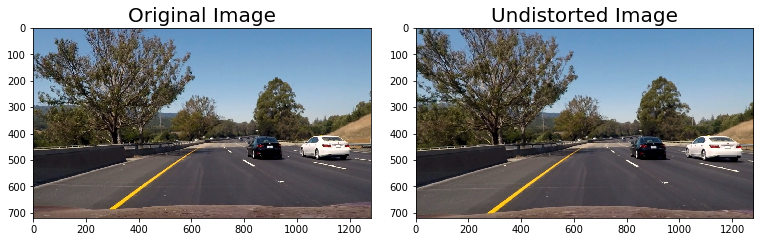

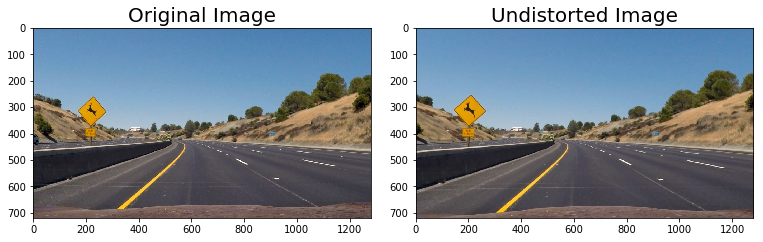

In [4]:
#images = glob.glob("camera_cal/calibration*.jpg")
images = glob.glob("test_images/*.jpg")
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)

for img_name in images:
    img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
    undistorted = undistort_img(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #f.savefig('output_images/calibration.png', bbox_inches="tight")
    
    



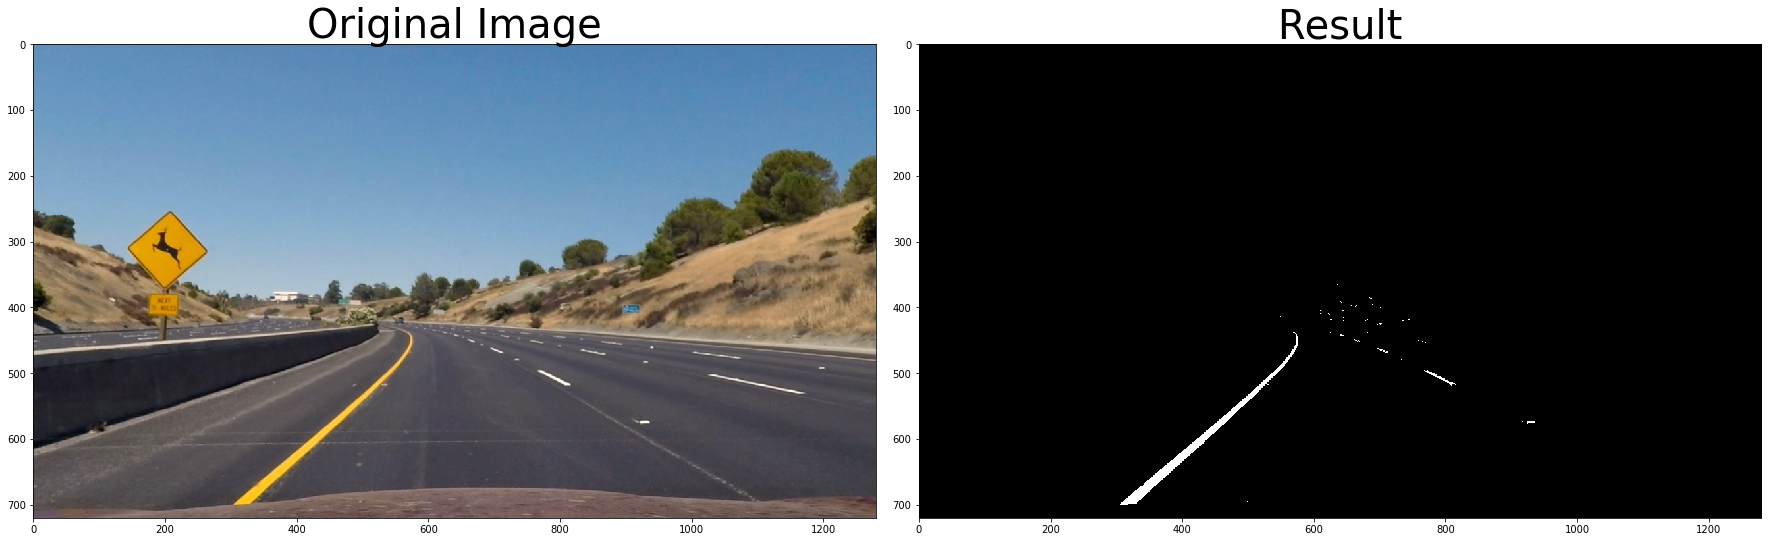

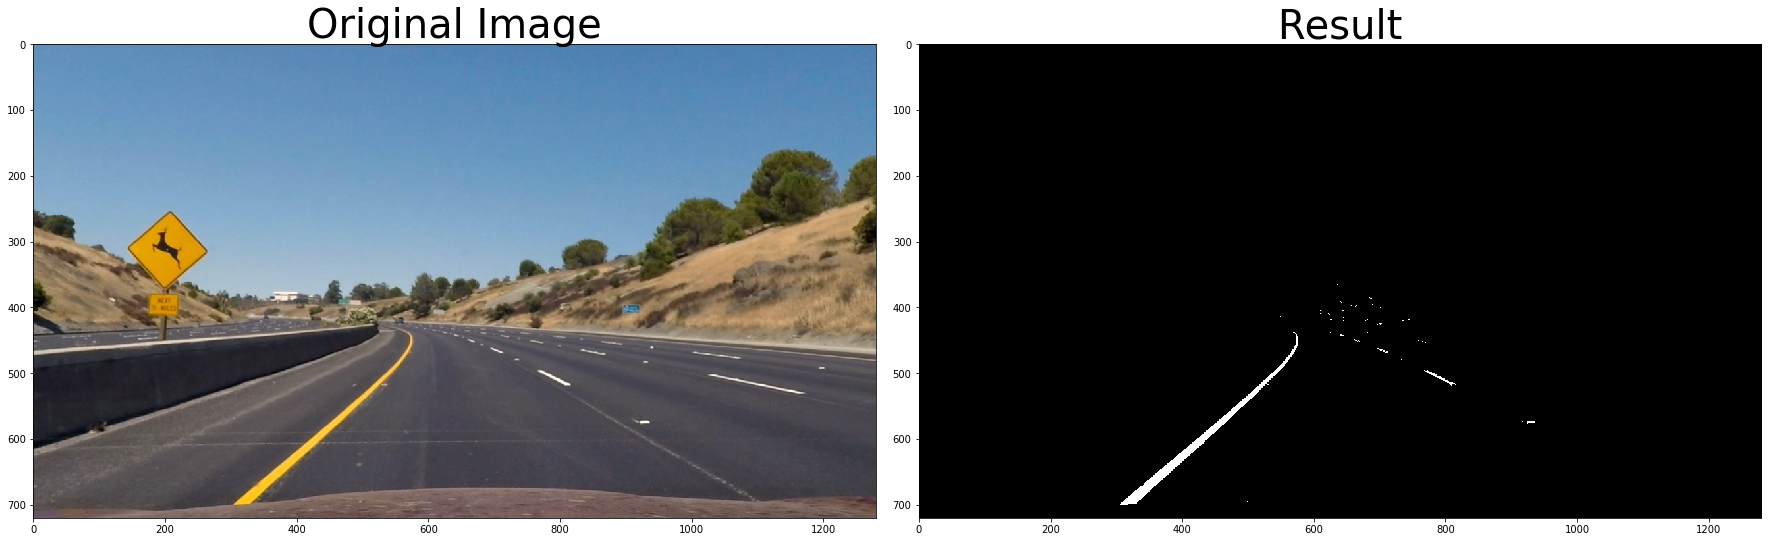

In [5]:
def binaryThresholded_img(img):
    
    
    #img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply gradient threshold on the horizontal gradient
    sx_thresh=(20, 100)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Apply gradient direction threshold 
    # kernel size
    sobel_kernel=3
    dir_thresh=(np.pi/6, np.pi/2)
    # apply Sobel x, Sobel y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #  calculate the direction of the gradient
    direction = np.arctan2(abs_sobely,abs_sobelx)
    direction = np.absolute(direction)
    # binary mask 
    dirbinary = np.zeros_like(direction)
    dirbinary[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    
    sxdirbinary = ((sxbinary==1)&(dirbinary==1))
    
    
    # Convert to HLS color space and separate the V channel
    s_thresh=(100, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]    
    # Threshold s channel for bright yellow and white line detection
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Colour threshold
    c_thresh = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    rgbinary = (R > c_thresh) & (G > c_thresh)
    
    # Lthreshold
    l_thresh = (120, 255)
    lbinary = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    # Stack each channel
    combinedbinary = np.zeros_like(R)
    #combinedbinary[(rgbinary & lbinary) & (sbinary | sxdirbinary)] = 1
    combinedbinary = (rgbinary & lbinary) & (sbinary | sxdirbinary)
    
    # Apply region of interest mask
    mask = np.zeros_like(s_channel)
    region_of_interest = np.array([[0,gray.shape[0]-1], [gray.shape[1]/2, int(0.5*gray.shape[0])], [gray.shape[1]-1, gray.shape[0]-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest], 1)
    color_binary = cv2.bitwise_and(combinedbinary, mask)
    
    return color_binary


img_name = 'test_images/test2.jpg'
img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)
undistorted = undistort_img(img)
result = binaryThresholded_img(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



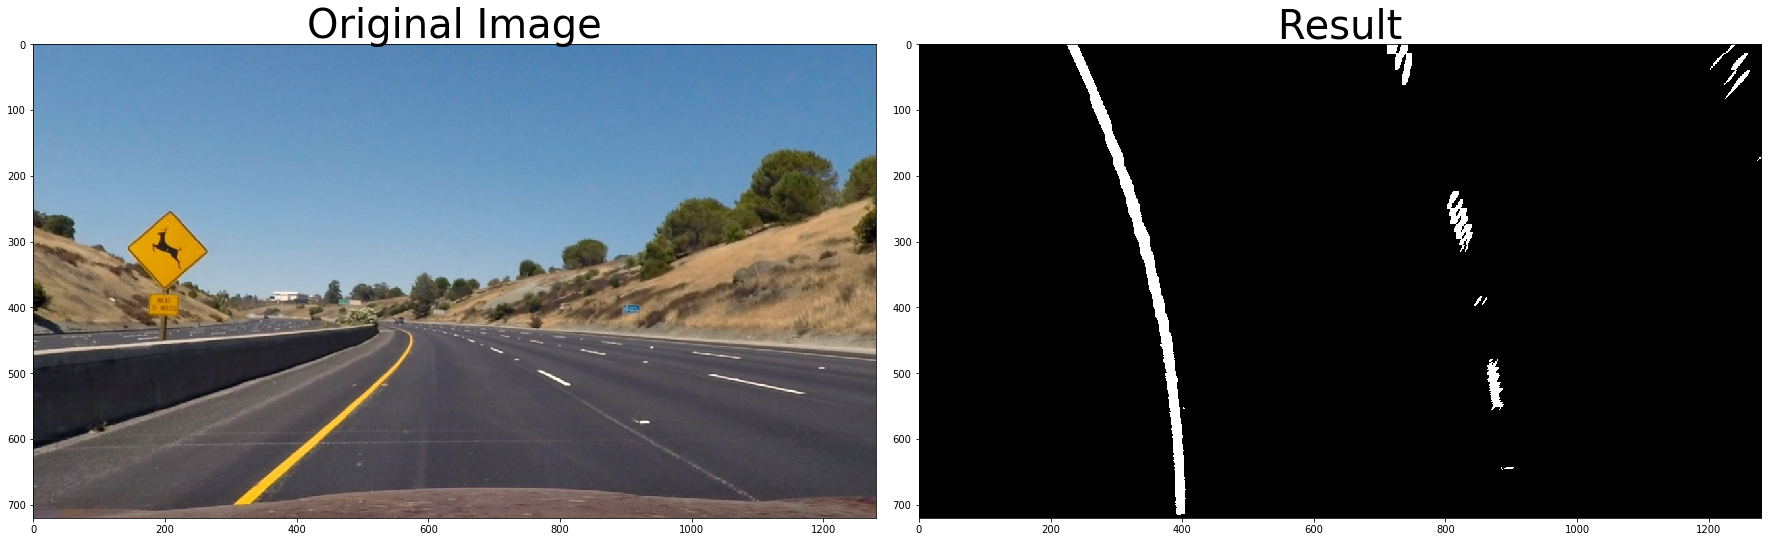

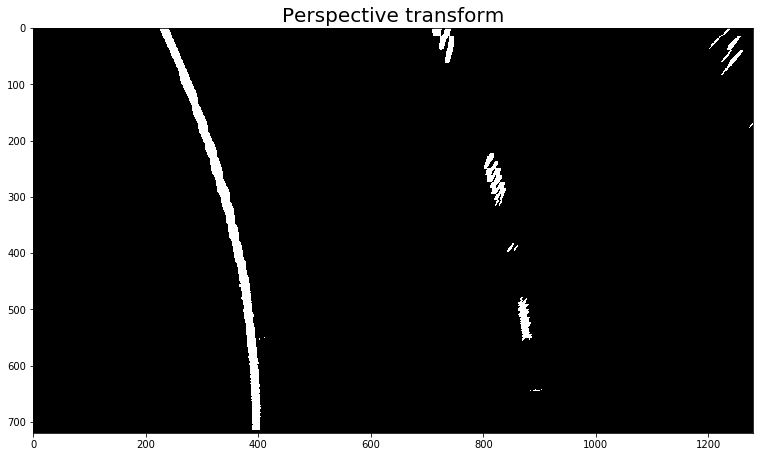

In [6]:
# Perspective transform

def prespective_transform(img):
    
    # manually define the vertices for perspecive transform
    leftbottom=[150,720] 
    rightbottom=[1250,720] 
    lefttop=[590,450] 
    righttop=[700,450]

    src=np.float32([leftbottom,lefttop,righttop,rightbottom])
    copy = img.copy()
    cv2.polylines(copy,np.int32(np.array([[leftbottom,lefttop,righttop,rightbottom]])),True,(0,0,255),5)
    
    # Destination points
    leftbottom = [320,720]
    rightbottom = [920, 720]
    lefttop = [320, 1]
    righttop = [920, 1]
    
    
    dst=np.float32([leftbottom,lefttop,righttop,rightbottom])
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])

    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    
    return warped, M, M_inv
    

img_name = 'test_images/test2.jpg'
img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)
undistorted = undistort_img(img)
binary_img = binaryThresholded_img(undistorted)
result,M,M_inv = prespective_transform(binary_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)






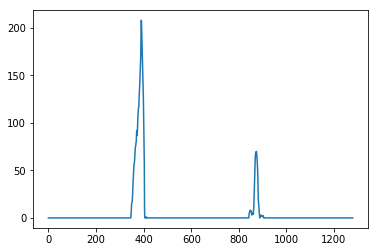

In [8]:
# Histogram
def histogram_warped(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Likely position of the left and right lane
    half_width = np.int(histogram.shape[0]//2)
    leftxbase = np.argmax(histogram[:half_width])
    rightxbase = np.argmax(histogram[half_width:]) + half_width
    plt.plot(histogram)
    
    return leftxbase,rightxbase
    

img_name = 'test_images/test2.jpg'
img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)
undistorted = undistort_img(img)
binary_img = binaryThresholded_img(undistorted)
result,M,M_inv = prespective_transform(binary_img)
q = histogram_warped(result)





[ -3.20916873e-04   4.60347411e-01   2.31682505e+02] [ -2.91913262e-04   4.42704794e-01   7.22970007e+02]


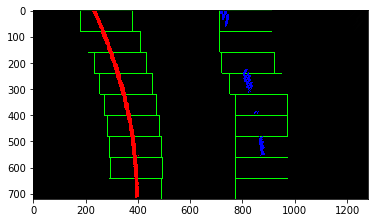

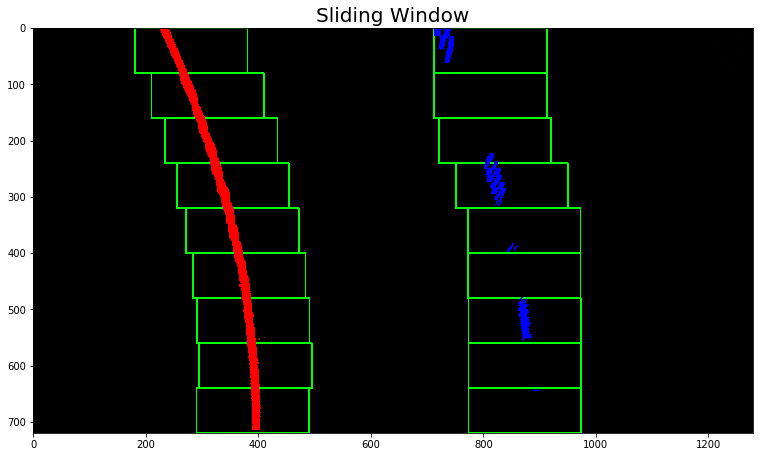

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # Width of the windows +/- margin
    margin = 100
    # Minimum number of pixels found to recenter window
    minpix = 50

    # Height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window 
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin   
        win_xright_low = rightx_current-margin  
        win_xright_high = rightx_current+margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window 
        ### (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)     
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` 
    left_fit = None
    right_fit = None
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)


    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
   
    
    return out_img, left_fit, right_fit


# plot sample

img_name = 'test_images/test2.jpg'
img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)
undistorted = undistort_img(img)
binary_img = binaryThresholded_img(undistorted)
result,M,M_inv = prespective_transform(binary_img)
out_img, left_fit, right_fit = fit_polynomial(result)
print(left_fit, right_fit)
plt.imshow(out_img)



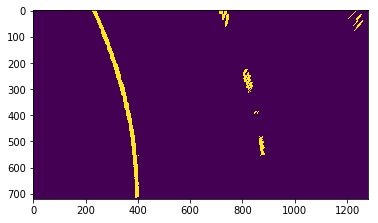

In [13]:
def search_around_poly(binary_warped, left_fitprev, right_fitprev):
    # Width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values 
    # within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > (left_fitprev[0]*(nonzeroy**2) + left_fitprev[1]*nonzeroy + 
                    left_fitprev[2] - margin)) & (nonzerox < (left_fitprev[0]*(nonzeroy**2) + 
                    left_fitprev[1]*nonzeroy + left_fitprev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fitprev[0]*(nonzeroy**2) + right_fitprev[1]*nonzeroy + 
                    right_fitprev[2] - margin)) & (nonzerox < (right_fitprev[0]*(nonzeroy**2) + 
                    right_fitprev[1]*nonzeroy + right_fitprev[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
   
    # Create an image to draw on and an image to show the selection window
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fitprev[0]*ploty**2 + left_fitprev[1]*ploty + left_fitprev[2]
    right_fitx = right_fitprev[0]*ploty**2 + right_fitprev[1]*ploty + right_fitprev[2]

    
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    return result, left_fit_new , right_fit_new 

# Test poly
out_img, left_fit, right_fit = search_around_poly(result,left_fit, right_fit)
plt.imshow(out_img)



In [19]:
def measure_curvature_real(binary_warped,left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    left_curverad = None
    right_curverad = None
    distance = None
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    

    positionCar= binary_warped.shape[1]/2

        
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    if right_fit is not None and left_fit is not None:
        leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
        rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculation of R_curve (radius of curvature) 
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    bottom_left_lane = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    bottom_right_lane = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Vehicle position assumed 
    VehiclePos= binary_warped.shape[1]/2
    
    # Find actual position
    actualPos= (bottom_left_lane+ bottom_right_lane)/2
    distance= (VehiclePos - actualPos)* xm_per_pix
    
    return left_curverad, right_curverad, distance


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, Vehdistance = measure_curvature_real(result, left_fit,right_fit)
print(left_curverad,right_curverad)
print(Vehdistance)

763.739742851 519.316188118
-0.559324410176


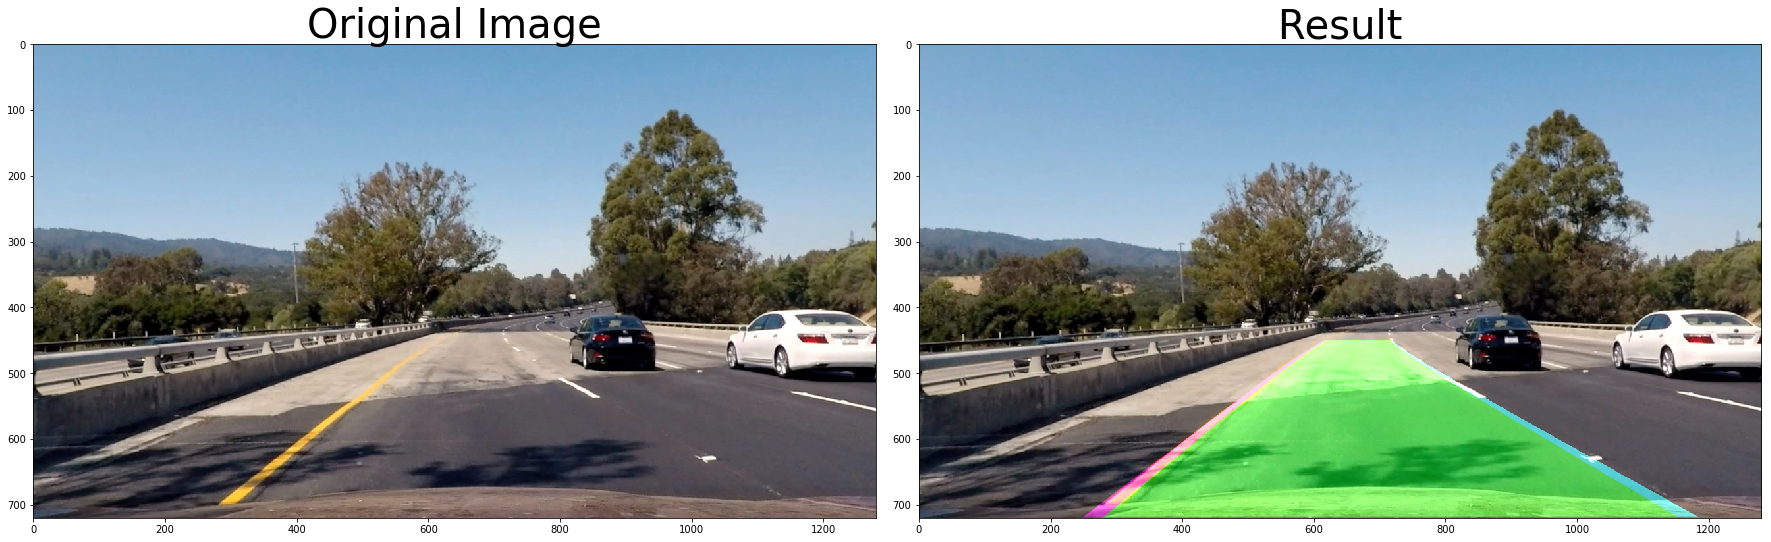

In [20]:
def drawLane(original_image,binary_warped, left_fit, right_fit, M_inv):
    
    h,w= binary_warped.shape
    # manually define the vertices for perspecive transform
    leftbottom=[150,720] 
    rightbottom=[1250,720] 
    lefttop=[590,450] 
    righttop=[700,450]

    src=np.float32([leftbottom,lefttop,righttop,rightbottom])
    copy = img.copy()
    cv2.polylines(copy,np.int32(np.array([[leftbottom,lefttop,righttop,rightbottom]])),True,(0,0,255),5)
    
    # Destination points
    leftbottom = [320,720]
    rightbottom = [920, 720]
    lefttop = [320, 1]
    righttop = [920, 1]
    
    # Destination 
    dst=np.float32([leftbottom,lefttop,righttop,rightbottom])
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
   
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result


img_name = 'test_images/test4.jpg'
img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)
undistorted = undistort_img(img)
binary_img = binaryThresholded_img(undistorted)
binary_warped,M,M_inv = prespective_transform(binary_img)
out_img, left_fit, right_fit = fit_polynomial(binary_warped)
finalimg = drawLane(undistorted, binary_warped, left_fit, right_fit, M_inv)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(finalimg,cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(finalimg)





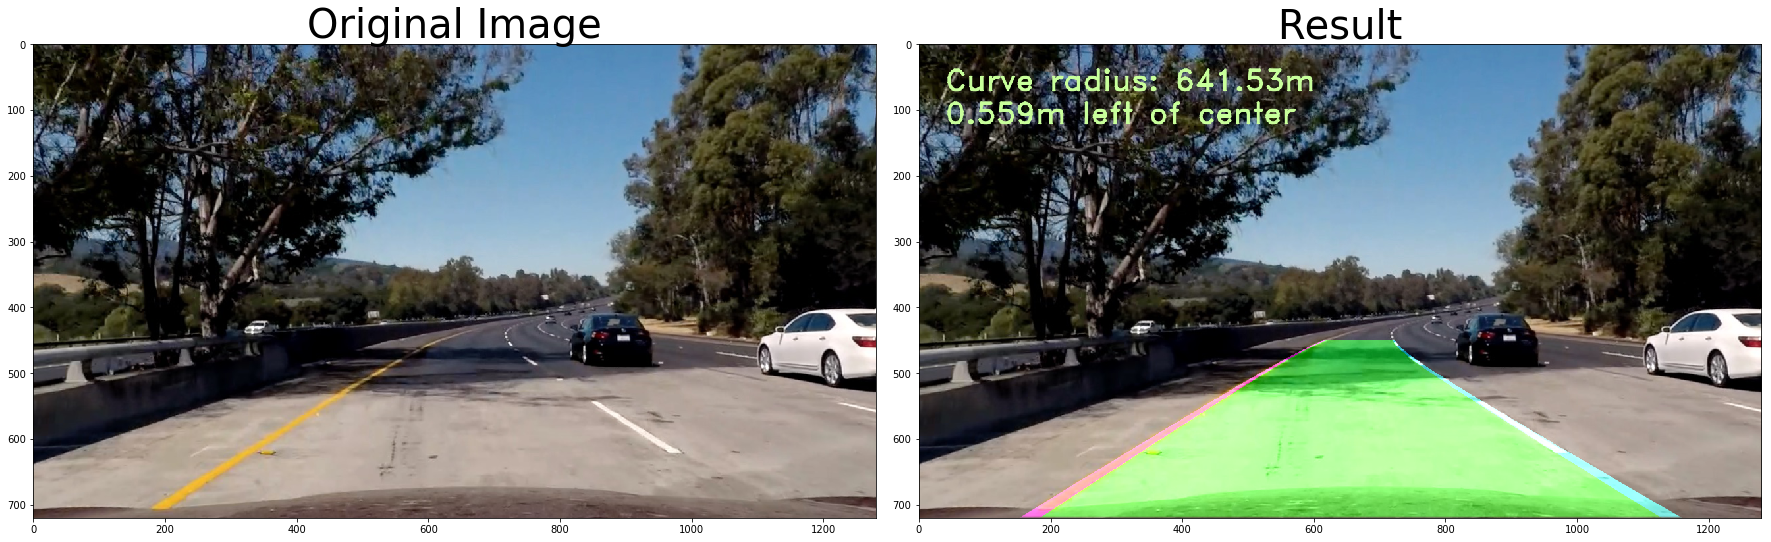

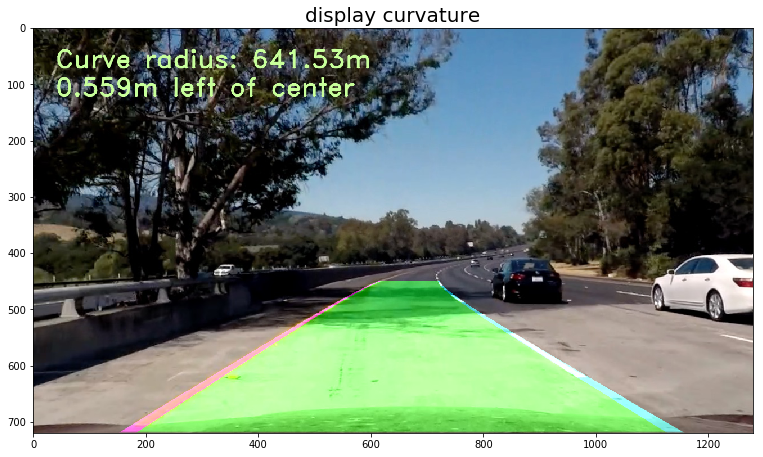

In [22]:
def draw_curvature_real(original_img, left_curverad, right_curverad, distance):
    # Anotate the radius of curvature and veh position 
    Vehdistance=distance
    curv_rad = 0.5*(left_curverad+right_curverad)
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if Vehdistance > 0:
        direction = 'right'
    elif Vehdistance < 0:
        direction = 'left'
    abs_Vehdistance = abs(Vehdistance)
    text = '{:04.3f}'.format(abs_Vehdistance) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

img_name = 'test_images/test5.jpg'
img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
objpoints, imgpoints = find_imgobj_points()
cameraMatrix, distortionCoeffs = camera_calibration(objpoints, imgpoints)
undistorted = undistort_img(img)
binary_img = binaryThresholded_img(undistorted)
binary_warped,M,M_inv = prespective_transform(binary_img)
out_img, left_fit, right_fit = fit_polynomial(binary_warped)
out_img, left_fit, right_fit = search_around_poly(binary_warped,left_fit, right_fit)
finalimg = drawLane(undistorted, binary_warped, left_fit, right_fit, M_inv)
left_curverad, right_curverad, Vehdistance = measure_curvature_real(result, left_fit,right_fit)
curveimg = draw_curvature_real(finalimg, left_curverad, right_curverad, Vehdistance)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(curveimg,cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(curveimg)




In [23]:
# Define a class to store properties of each line 
class Line():
    def __init__(self):
        # Line detected in the last iteration
        self.is_detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # Avg x values of the fitted line over the last n iterations
        self.bestx = None 
        # Previous fit
        self.prev_fit = None  
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Polynomial coefficients of current fit
        self.current_fit = []  
        # Radius of curvature of the line 
        self.radius_of_curvature = None 
        # Veh distance of vehicle center from the line
        self.line_base_pos = None 
        # Difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # Number of detected pixels
        self.px_count = None
    def process_fit(self, fit):
        # Add a fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # If we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # bad fit! 
                self.is_detected = False
            else:
                self.is_detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 10:
                    # Discard old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.is_detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

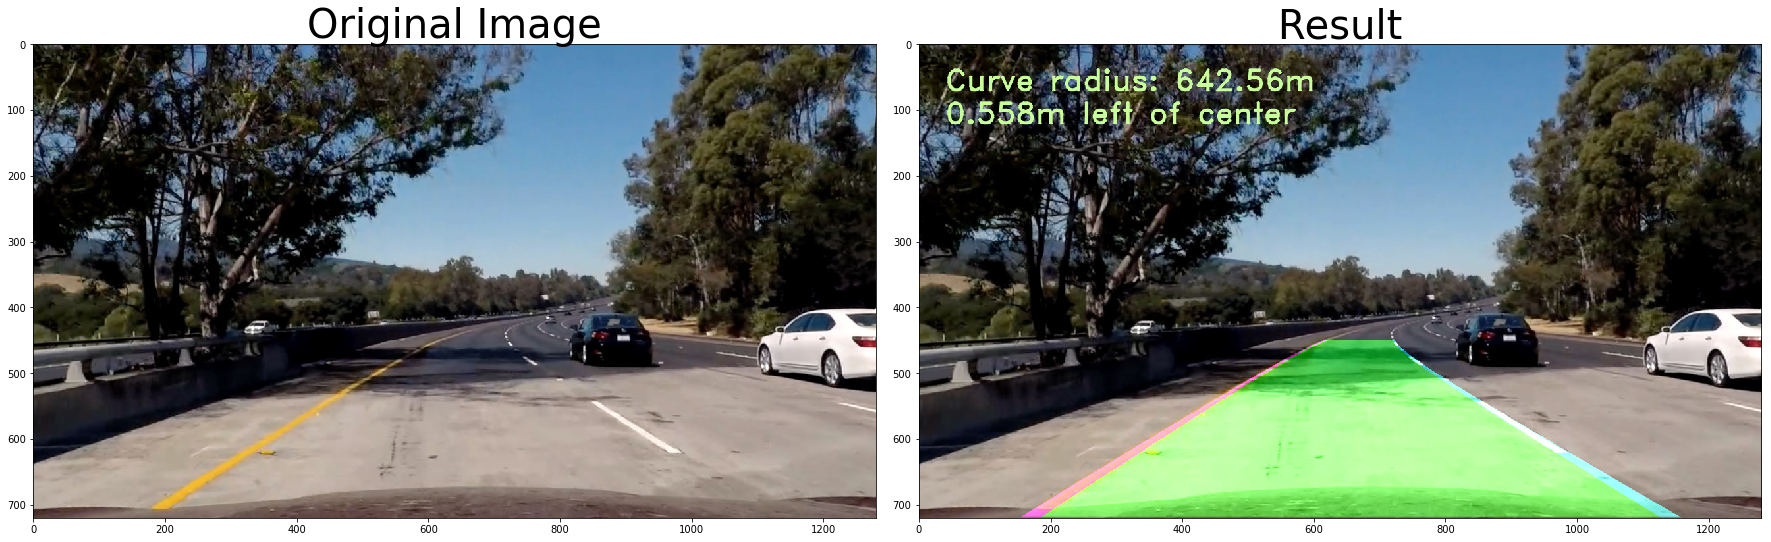

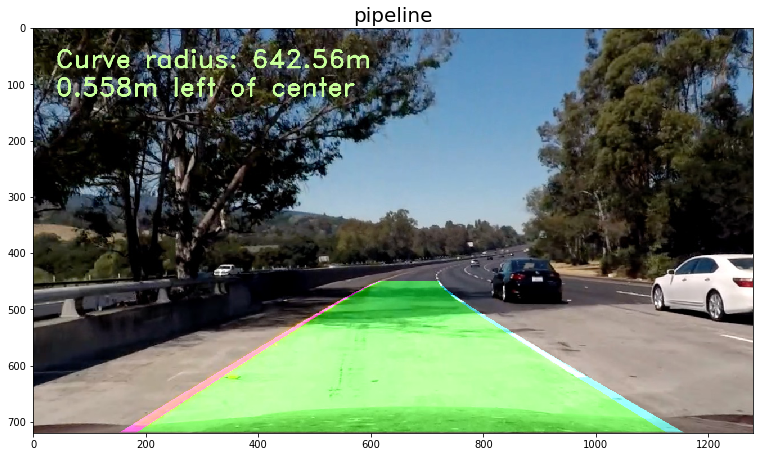

In [25]:
# Pipeline for video processing

def process_video(inputimg):
    
    
    #make a copy of the original image
    img = np.copy(inputimg)
    
    #apply undistortion and color thresholding on the image 
    undistorted = undistort_img(img)
    binary_img = binaryThresholded_img(undistorted)
    binary_warped,M,M_inv = prespective_transform(binary_img)
    
    # use polyfit_using_prev_fit, otherwise use sliding window fit
    if not l_line.is_detected or not r_line.is_detected:
        out_img, left_fit, right_fit = fit_polynomial(binary_warped)
    else:
        out_img, left_fit, right_fit = search_around_poly(binary_warped,l_line.best_fit, r_line.best_fit)
    
                  
    l_line.process_fit(left_fit)
    r_line.process_fit(right_fit)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:        
        out1 = drawLane(undistorted, binary_warped, l_line.best_fit, r_line.best_fit, M_inv)
        left_curverad, right_curverad, Vehdistance = measure_curvature_real(binary_warped, l_line.best_fit, r_line.best_fit)
        out2 = draw_curvature_real(out1, left_curverad, right_curverad, Vehdistance)
        outputimg = out2
        l_line.prev_fit = left_fit
        r_line.prev_fit = right_fit
    else:
        #outputimg = img
        out1 = drawLane(undistorted, binary_warped, l_line.prev_fit, r_line.prev_fit, M_inv)
        left_curverad, right_curverad, Vehdistance = measure_curvature_real(binary_warped, l_line.prev_fit, r_line.prev_fit)
        out2 = draw_curvature_real(out1, left_curverad, right_curverad, Vehdistance)
        outputimg = out2
    return outputimg


img_name = 'test_images/test5.jpg'
img_name = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
l_line = Line()
r_line = Line()

resimg = process_video(img_name)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(curveimg,cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(resimg)



In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
# Process video

l_line = Line()
r_line = Line()

video_output1 = 'harder_challenge_video_processed.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
processed_clip = clip1.fl_image(process_video)
%time processed_clip.write_videofile(video_output1, audio=False)





[MoviePy] >>>> Building video harder_challenge_video_processed.mp4
[MoviePy] Writing video harder_challenge_video_processed.mp4


100%|█████████▉| 1199/1200 [06:30<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_processed.mp4 

CPU times: user 3min 22s, sys: 31.1 s, total: 3min 53s
Wall time: 6min 35s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))